In [29]:
import fitsio
import os, glob
import fitsio
from scipy.ndimage.filters import gaussian_filter 
from scipy.signal import convolve2d
from scipy.io import readsav
import numpy as np
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from pathlib import Path
import time
import numpy as np

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})

In [47]:
def quiver_plot(ax, vx, vy, step=1, dx=1, vunit=1, scale=30, shaftwidth=0.1, headwidth=3, headlength=4, headaxislength=4.5, title='', axis=None):
    v_slice = np.s_[::step, ::step]
    # Grid of the flow fields, first define the default, then slice it to match anchors spaced by "step" pixels
    x, y = np.meshgrid(np.arange(vx.shape[0]), np.arange(vx.shape[1]))
    x = x[v_slice]*dx
    y = y[v_slice]*dx
    # Slice the velocity to match anchor spacing
    vx_s = vx[v_slice] * vunit
    vy_s = vy[v_slice] * vunit

    ### norm of velocity for color mapping
    # vnorm = np.sqrt(vx_s ** 2 + vy_s ** 2)
    
    quiv = ax.quiver(x, y, vx_s, vy_s,
               units='xy', scale=scale, width=shaftwidth, headwidth=headwidth, headlength=headlength, headaxislength=headaxislength, label='V (m/s)')
    ax.set_aspect('equal')
    ax.axis([0, vx.shape[1]*dx, 0, vx.shape[0]*dx])
    
    if axis is not None:
        ax.axis(axis)
        
    ax.set_xlabel('x [Mm]')
    ax.set_ylabel('y [Mm]')

    return quiv

In [151]:
# lons = [-7, -67, -77]
# Longitudes (Carrington):
lonCRs = [60, 0, 350]
# Latitudes
lats = [0, 60, 70]
lon_lats_stony = [(-7, 0), (-7, 60), (-7, 70), (-67, 0), (-77, 0)]

lon_lats = [(60.4, 0), (60.4, 60), (60.4, 70), (0, 0), (350, 0)]
nevents = len(lon_lats)
basenames = ['mtrack_20110627_200034_TAI_20110628_000033_TAI_Postel_{:05.1f}_{:04.1f}_magnetogram.fits'
                 .format(lon_lat[0], lon_lat[1]) for lon_lat in lon_lats]
# Get the magnetograms and lanes files
magfiles = [os.path.join(os.environ['DATA'], 'SDO/HMI/polar_study/', basename) for basename in basenames]
lanesdirs = [os.path.join(os.environ['DATA'], 'SDO/HMI/polar_study/lonCR_{:05.1f}_lat_{:04.1f}'.format(lon_lat[0], lon_lat[1]))
                for lon_lat in lon_lats]

for f in magfiles: print(f)
for f in lanesdirs: print(f)

/mnt/data2/SDO/HMI/polar_study/mtrack_20110627_200034_TAI_20110628_000033_TAI_Postel_060.4_00.0_magnetogram.fits
/mnt/data2/SDO/HMI/polar_study/mtrack_20110627_200034_TAI_20110628_000033_TAI_Postel_060.4_60.0_magnetogram.fits
/mnt/data2/SDO/HMI/polar_study/mtrack_20110627_200034_TAI_20110628_000033_TAI_Postel_060.4_70.0_magnetogram.fits
/mnt/data2/SDO/HMI/polar_study/mtrack_20110627_200034_TAI_20110628_000033_TAI_Postel_000.0_00.0_magnetogram.fits
/mnt/data2/SDO/HMI/polar_study/mtrack_20110627_200034_TAI_20110628_000033_TAI_Postel_350.0_00.0_magnetogram.fits
/mnt/data2/SDO/HMI/polar_study/lonCR_060.4_lat_00.0
/mnt/data2/SDO/HMI/polar_study/lonCR_060.4_lat_60.0
/mnt/data2/SDO/HMI/polar_study/lonCR_060.4_lat_70.0
/mnt/data2/SDO/HMI/polar_study/lonCR_000.0_lat_00.0
/mnt/data2/SDO/HMI/polar_study/lonCR_350.0_lat_00.0


In [43]:
len(lanesdirs), len(vxf), len(vyf)

(5, 36, 36)

[[0, 40], [0, 48], [0, 56], [0, 64], [0, 72], [0, 80], [0, 88], [0, 96], [0, 104], [0, 112], [0, 120], [0, 128], [0, 136], [0, 144], [0, 152], [0, 160], [0, 168], [0, 176], [0, 184], [0, 192], [0, 200], [0, 208], [0, 216], [0, 224], [0, 232], [0, 240], [0, 248], [0, 256], [0, 264], [0, 272], [0, 280], [0, 288], [0, 296], [0, 304], [0, 312], [0, 320]]


In [128]:
lambda2 = 80 * np.pi/180
phi2 = 0
beta = np.arcsin(np.sin(lambda2) * np.sin(np.pi/2))* 180/np.pi

79.99999999999999

In [141]:
def beta(lon, lat):
    lon = np.abs(lon) * np.pi/180
    lat = np.abs(lat) * np.pi/180
    dl = np.abs(lon - lat)
    
    cos_angle = np.cos(lat) * np.cos(lon)
    return cos_angle

In [143]:
cos_betas = np.array([beta(*lonlat) for lonlat in lon_lats_stony])
np.arccos(cos_betas)*180/np.pi

array([ 7.        , 60.24626652, 70.15536576, 67.        , 77.        ])

[[0, 40], [0, 48], [0, 56], [0, 64], [0, 72], [0, 80], [0, 88], [0, 96], [0, 104], [0, 112], [0, 120], [0, 128], [0, 136], [0, 144], [0, 152], [0, 160], [0, 168], [0, 176], [0, 184], [0, 192], [0, 200], [0, 208], [0, 216], [0, 224], [0, 232], [0, 240], [0, 248], [0, 256], [0, 264], [0, 272], [0, 280], [0, 288], [0, 296], [0, 304], [0, 312], [0, 320]]
/mnt/data2/SDO/HMI/polar_study/mtrack_20110627_200034_TAI_20110628_000033_TAI_Postel_060.4_70.0_magnetogram.fits
/mnt/data2/SDO/HMI/polar_study/lonCR_060.4_lat_70.0


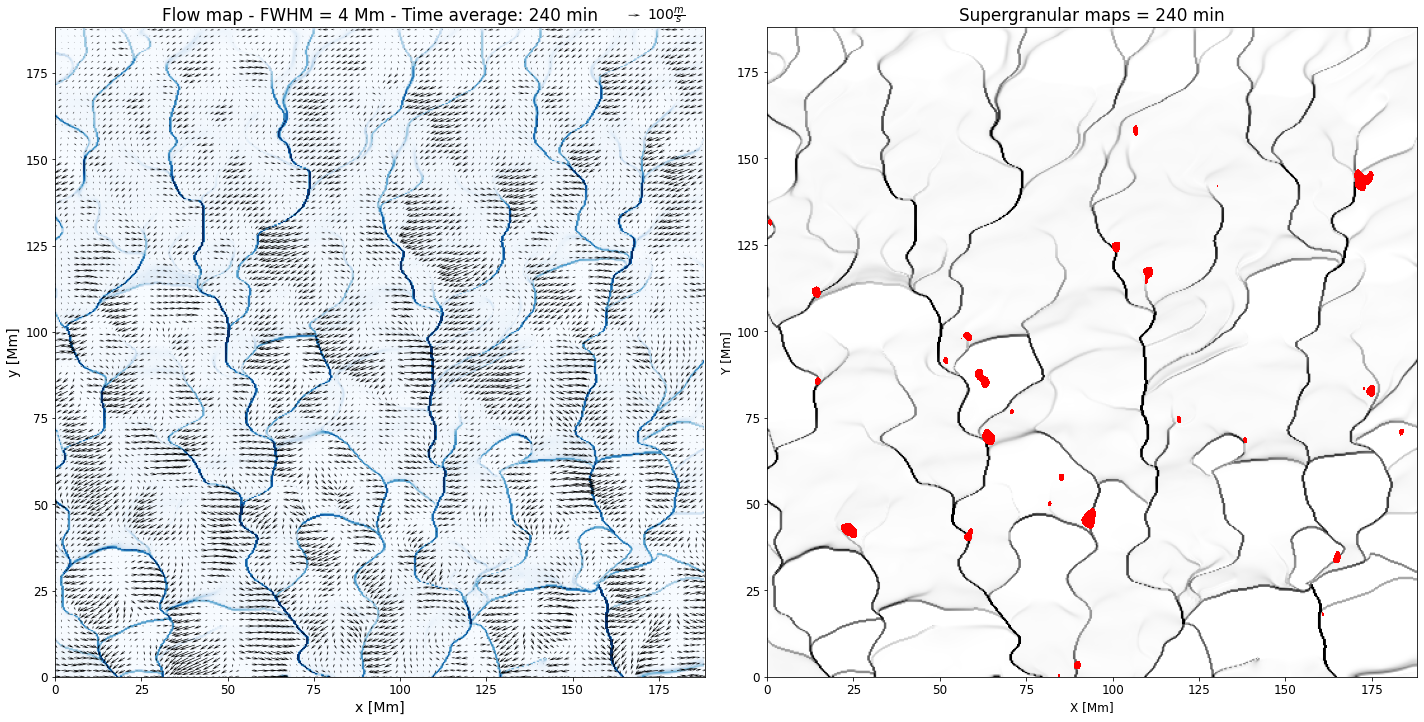

In [171]:
fwhm = 11
nframes = 320
tavgs = range(40, nframes+1, 8)
tranges = [[0, tavg] for tavg in tavgs]
print(tranges)
nflows = len(tranges)

dx = 368/1000 # Mm
x = np.arange(512) * dx
y = x

vunit = 368000/45 # ms



for idx, lanesdir in enumerate(lanesdirs[2:3]):

    idx = 2
    magfile = magfiles[idx]
    # Get all the lanes files at 11 px
    lanes_files = sorted(glob.glob(os.path.join(lanesdir, 'widening_average', 'lanes_fwhm{:d}*.fits'.format(fwhm))))
    # Average of unsigned flux at increasing time averages
    mag = fitsio.read(magfile)

    print(magfile)
    print(lanesdir)
    for i,trange in enumerate(tranges[-1:]):

        i = 35
        vxf = sorted(Path(lanesdir, 'widening_average').glob('vx_fwhm11_tavg*.fits'))
        vyf = sorted(Path(lanesdir, 'widening_average').glob('vy_fwhm11_tavg*.fits'))
        vx_widen = np.array([fitsio.read(f) for f in vxf])
        vy_widen = np.array([fitsio.read(f) for f in vyf])
        
        tavg_min = int(np.round(trange[1]*45/60))
        lanes = fitsio.read(lanes_files[i])

        mag_abs = np.abs(mag)
        mag_abs_avg = mag_abs[trange[0]:trange[1], ...].mean(axis=0)


        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
        
        vx = vx_widen[i]
        vy = vy_widen[i]
        trange = tranges[i]
        tavg_min = int(np.round(trange[1]*45/60))
        axs[0].imshow(lanes, cmap='Blues', origin='lower', extent=(0, x[-1], 0, y[-1]), vmin=0, vmax=40)
        q1 = quiver_plot(axs[0], vx, vy, step=5, dx=dx, vunit=vunit, scale=150, shaftwidth=0.2, headwidth=5, headlength=10, headaxislength=5)
        axs[0].set_title(f'Flow map - FWHM = 4 Mm - Time average: {tavg_min} min')
        qk1 = axs[0].quiverkey(q1, 0.45, 0.98, 500, r'$100 \frac{m}{s}$', labelpos='E', coordinates='figure')
        
        axs[1].imshow(lanes, cmap='gray_r', origin='lower', extent=(0, x[-1], 0, y[-1]), vmin=0, vmax=40)
        axs[1].contourf(mag_abs_avg/cos_betas[idx], np.linspace(80,1000,50), colors ='red', extent=(0, x[-1], 0, y[-1]))
        axs[1].set_xlabel('X [Mm]', fontsize=12)
        axs[1].set_ylabel('Y [Mm]', fontsize=12)
        axs[1].set_title('Supergranular maps = {:d} min'.format(tavg_min))
        
        plt.tight_layout()
#         figf = os.path.join(lanesdir, 'widening_average', 'lanes_mag_{:03d}.jpg'.format(i))
#         plt.savefig(figf)
#         plt.close()

In [164]:
len(tranges)

36

In [127]:
tstarts = np.arange(0, nframes-80, 40)
tranges = [[t1, t1+80] for t1 in tstarts]
tavg_min = 60

for idx, lanesdir in enumerate(lanesdirs):

    magfile = magfiles[idx]
    # Get all the lanes files at 11 px
    lanes_files = sorted(glob.glob(os.path.join(lanesdir, 'sliding_average', 'lanes_fwhm{:d}*.fits'.format(fwhm))))
    # Average of unsigned flux at increasing time averages
    mag = fitsio.read(magfile)

    for i,trange in enumerate(tranges):

        vxf = sorted(Path(lanesdir, 'sliding_average').glob('vx_fwhm11_tavg*.fits'))
        vyf = sorted(Path(lanesdir, 'sliding_average').glob('vy_fwhm11_tavg*.fits'))
        vx_widen = np.array([fitsio.read(f) for f in vxf])
        vy_widen = np.array([fitsio.read(f) for f in vyf])

        lanes = fitsio.read(lanes_files[i])

        mag_abs = np.abs(mag)
        mag_abs_avg = mag_abs[trange[0]:trange[1], ...].mean(axis=0)


        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
        
        vx = vx_widen[i]
        vy = vy_widen[i]
        trange = tranges[i]
        tavg_min = int(np.round(trange[1]*45/60))
        axs[0].imshow(lanes, cmap='Blues', origin='lower', extent=(0, x[-1], 0, y[-1]), vmin=0, vmax=20)
        q1 = quiver_plot(axs[0], vx, vy, step=5, dx=dx, vunit=vunit, scale=150, shaftwidth=0.2, headwidth=5, headlength=10, headaxislength=5)
        axs[0].set_title(f'Flow map - FWHM = 4 Mm - Time average: {tavg_min} min')
        qk1 = axs[0].quiverkey(q1, 0.45, 0.98, 500, r'$100 \frac{m}{s}$', labelpos='E', coordinates='figure')
        
        axs[1].imshow(lanes, cmap='gray_r', origin='lower', extent=(0, x[-1], 0, y[-1]), vmin=0, vmax=20)
        axs[1].contourf(mag_abs_avg, np.linspace(50,1000,50), colors ='red', extent=(0, x[-1], 0, y[-1]))
        axs[1].set_xlabel('X [Mm]', fontsize=12)
        axs[1].set_ylabel('Y [Mm]', fontsize=12)
        axs[1].set_title('Supergranular maps = {:d} min'.format(tavg_min))
        
        plt.tight_layout()
        figf = os.path.join(lanesdir, 'sliding_average', 'lanes_mag_{:03d}.jpg'.format(i))
        plt.savefig(figf)
        plt.close()